In [1]:
![ -f tinyshakespear.txt ] || curl -L -o tinyshakespear.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [2]:
import torch as th
import numpy as np

In [3]:
import re
from gensim.models import Word2Vec

with open('tinyshakespear.txt', 'r') as f:
    corpus = f.read()

PADDING_TOKEN = '<pad>'
UNKOWN_TOKEN = '<unk>'
sentences  = []
START_OF_SENTENCE = "<sos>"
END_OF_SENTENCE = "<eos>"

sentence_sizes = []
for sentence in corpus.strip().lower().split('.'):
    sent =  re.findall(r"[a-z]+", sentence)
    if len(sent) == 0:
        continue

    sentence_sizes.append(len(sent))
        
    sentences.append(
        [START_OF_SENTENCE] + sent +  [END_OF_SENTENCE]
    )

embedding_dim = 50
word_embeddings = Word2Vec(
    # just including the extra tokens
    sentences + [[PADDING_TOKEN, PADDING_TOKEN, UNKOWN_TOKEN]],
    vector_size=embedding_dim,
    window=5,
    min_count=1,
    workers=4,
    sg=1
)

vocabulary = {word: i for i, word in enumerate(word_embeddings.wv.index_to_key)}
reverse_index = {i: x for x, i in vocabulary.items()}

PADDING_ID = vocabulary[PADDING_TOKEN]
UNKOWN_ID = vocabulary[UNKOWN_TOKEN]

def encode_sentence(sentence: list[str]):
    return [vocabulary.get(word, UNKOWN_ID) for word in sentence]

encoded_sentences = [encode_sentence(sentence) for sentence in sentences]

def decode_sentence(sentence: list[int]):
    return [reverse_index[x] for x in sentence]

print("Vocab size:", len(vocabulary))
print("Total sentences:", len(sentences))
min_size, max_size = min(sentence_sizes), max(sentence_sizes)
mean, std = np.mean(sentence_sizes), np.std(sentence_sizes)
median = np.median(sentence_sizes)
print(f"Sentence distribution: min:{min_size} 50%:{median} max:{max_size} (mean:{mean}; std:{std})") 

Vocab size: 11459
Total sentences: 7885
Sentence distribution: min:1 50%:19.0 max:259 (mean:26.4429930247305; std:23.505672288255084)


# Simple LSTM Model

In [4]:
class SimpleLSTM(th.nn.Module):
    def __init__(self, input_embedd_dim: int, hidden_dim: int, vocab: dict[str,int] , word_embeddings: Word2Vec | None = None, freeze_embedding_weight = True):
        super().__init__()
        vocab_size = len(vocab)
        if word_embeddings == None:
            self.embeddings = th.nn.Embedding(vocab_size, input_embedd_dim)
        else:
            # https://docs.pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding.from_pretrained
            embedding_matrix = th.zeros(vocab_size, input_embedd_dim)
            for word, idx in vocab.items():
                embedding_matrix[idx] = th.tensor(word_embeddings.wv[word])
                
            self.embeddings = th.nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze_embedding_weight)
            
        self.lstm = th.nn.LSTM(
            input_size=input_embedd_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )

        self.fc = th.nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x: th.Tensor, hidden=None):
        # x: (batch, seq_len)
        inp = self.embeddings(x)
        out, hidden = self.lstm(inp, hidden)
        # out: (batch, seq_len, hidden_size)
        logits = self.fc(out)
        # logits: (batch, seq_len, vocab_size
        return logits, hidden

In [5]:
import random
def batch_generator(sentences: list[list[int]], seq_len: int, batch_size: int,
                    padding_id: int = PADDING_ID, shuffle: bool = True, min_size: int = 2):
    
    if shuffle:
        sentences = sentences.copy()
        random.shuffle(sentences)

    batch_inputs = []
    batch_targets = []

    for sentence in sentences:
        for i in range(0, len(sentence), seq_len):
            chunk = sentence[i : i+seq_len+1]
            if len(chunk) < min_size:
                continue 
                
            inp = chunk[:-1]
            tgt = chunk[1:]
            # P(token_{i+1} | token_i), so the training data has input batch
            # the target is the window shifted onestep to the right
            if len(inp) < seq_len:
                pad_amt = seq_len - len(inp)
                inp += [padding_id]*pad_amt
                tgt += [padding_id]*pad_amt
                
            batch_inputs.append(inp)
            batch_targets.append(tgt)

            if len(batch_inputs) == batch_size:
                yield (
                    th.tensor(batch_inputs),
                    th.tensor(batch_targets),
                )
                batch_inputs, batch_targets = [], []
                
    if batch_inputs:
        yield (
            th.tensor(batch_inputs),
            th.tensor(batch_targets),
        )
        
for inpt, target in batch_generator(encoded_sentences,seq_len=5, batch_size=3, shuffle=False):
    print("Input data:")
    for x in inpt:
        print(x, decode_sentence(x.tolist()))
    print("Target data:")
    for y in target:
        print(y, decode_sentence(y.tolist()))
    break

Input data:
tensor([  1,  94, 279, 146,  34]) ['<sos>', 'first', 'citizen', 'before', 'we']
tensor([1020,  152,  685,  132,   18]) ['proceed', 'any', 'further', 'hear', 'me']
tensor([ 109, 4793, 4793, 4793, 4793]) ['speak', '<pad>', '<pad>', '<pad>', '<pad>']
Target data:
tensor([  94,  279,  146,   34, 1020]) ['first', 'citizen', 'before', 'we', 'proceed']
tensor([152, 685, 132,  18, 109]) ['any', 'further', 'hear', 'me', 'speak']
tensor([   0, 4793, 4793, 4793, 4793]) ['<eos>', '<pad>', '<pad>', '<pad>', '<pad>']


In [6]:
seq_len = 10
batch_size = 512
epochs = 10
log_batch = 10 # every n batch log the loss
eta = 0.001
hidden_dim = 128

sentence_yapper = SimpleLSTM(input_embedd_dim=embedding_dim, hidden_dim=hidden_dim, vocab=vocabulary, 
                             word_embeddings=word_embeddings, freeze_embedding_weight=False)
criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(sentence_yapper.parameters(), lr=eta)

losses = []
vocab_size = len(vocabulary)
for i in range(epochs):
    print(f"Epoch #{i+1}...")
    for i, (inputs, targets) in enumerate(batch_generator(encoded_sentences, seq_len=seq_len, 
                                           batch_size=batch_size, shuffle=True)):
        optimizer.zero_grad()
        logits, _ = sentence_yapper(inputs)
    
        loss = criterion(
            logits.view(-1, vocab_size),
            targets.view(-1)
        )
    
        loss.backward()
        optimizer.step()
        loss_val = loss.item()
        losses.append(loss_val)
        if (i % log_batch) == 0:
            print(f"Batch #{i+1}: loss: {loss_val:.5f}")
    print(f"Batch #{i+1}: epoch final loss: {loss_val:.5f}")      

Epoch #1...
Batch #1: loss: 9.34936
Batch #11: loss: 9.09559
Batch #21: loss: 7.72150
Batch #31: loss: 6.61515
Batch #41: loss: 6.41068
Batch #50: epoch final loss: 5.83588
Epoch #2...
Batch #1: loss: 6.29207
Batch #11: loss: 6.21285
Batch #21: loss: 6.26520
Batch #31: loss: 6.18029
Batch #41: loss: 6.10999
Batch #50: epoch final loss: 5.75706
Epoch #3...
Batch #1: loss: 6.05857
Batch #11: loss: 5.97440
Batch #21: loss: 6.04778
Batch #31: loss: 5.96997
Batch #41: loss: 5.96513
Batch #50: epoch final loss: 5.85057
Epoch #4...
Batch #1: loss: 5.95875
Batch #11: loss: 5.85478
Batch #21: loss: 5.84739
Batch #31: loss: 5.82452
Batch #41: loss: 5.89623
Batch #50: epoch final loss: 5.91098
Epoch #5...
Batch #1: loss: 5.83406
Batch #11: loss: 5.78138
Batch #21: loss: 5.89777
Batch #31: loss: 5.77388
Batch #41: loss: 5.78155
Batch #50: epoch final loss: 5.16019
Epoch #6...
Batch #1: loss: 5.71764
Batch #11: loss: 5.60981
Batch #21: loss: 5.78579
Batch #31: loss: 5.63683
Batch #41: loss: 5.78726

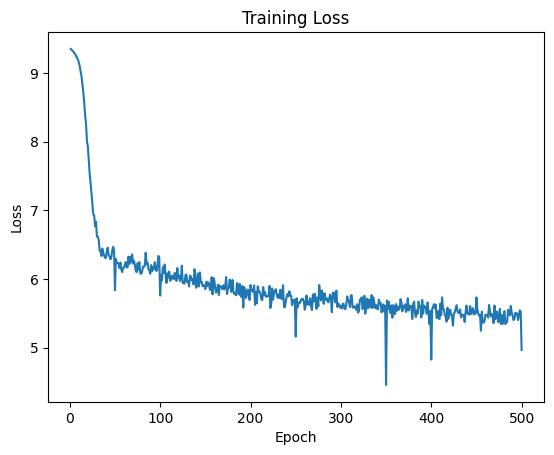

In [7]:
import matplotlib.pyplot as plt

updates = list(range(1, len(losses)+1))
plt.figure()
plt.plot(updates, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [8]:
def sample_sentence(model, seed_sentence: str, max_len: int =100, greedy=False, generations = 5):

    start_words = seed_sentence.split(' ')
    
    seed_sequence = [vocabulary[START_OF_SENTENCE]]
    for word in start_words:
        seed_sequence.append(vocabulary.get(word, UNKOWN_ID))
        
  
    seed_sentence = [START_OF_SENTENCE]
    for word in start_words:
        seed_sentence.append(word)
    
    if greedy and generations > 1:
        generations = 1

    all_generated_sentences = []
    
    for i in range(1, generations+1):
        sequence = seed_sequence.copy()
        input_ids = th.tensor(sequence, dtype=th.long).unsqueeze(0)
        hidden = None
        
        print(f"{i})",end ="")
        for word in seed_sentence:
            print(word, end=" ")

        with th.no_grad():
            for _ in range(max_len):
                logits, hidden = model(input_ids, hidden)
                next_logits = logits[:, -1, :]
    
                if greedy:
                    next_id = next_logits.argmax(dim=-1)
                else:
                    probs = th.softmax(next_logits, dim=-1)
                    next_id = th.multinomial(probs, 1).squeeze(1)
    
                input_ids = next_id.unsqueeze(1)
                sequence.append(next_id.item())
                word = reverse_index[sequence[-1]] 
                print(word, end= " ") 
                if word == END_OF_SENTENCE:
                    break
        print()      
        all_generated_sentences.append(sequence)
        
    return all_generated_sentences

In [11]:
yap = sample_sentence(sentence_yapper, seed_sentence="the woman and man",greedy=False)

1)<sos> the woman and man he in more half lord <eos> 
2)<sos> the woman and man that him to noise it for good is the pitying ever and volscian late <eos> 
3)<sos> the woman and man at putting beseech feel thou as take ghastly any mates of see and hurt to were er in do for whose by sweet agrees none to bend and pray with <eos> 
4)<sos> the woman and man hold beseech please i from set when for be yours to let and not traitor hath with too the blood to a lion <eos> 
5)<sos> the woman and man s rush go <eos> 
